In [56]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# import libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [58]:
from google.colab import output
output.enable_custom_widget_manager()

# Load Data

In [59]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [60]:
train.head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,voice_gender,mode,speechiness,tempo,musician_category,valence,music_genre
0,MSC_83537.0,Estrellitas y Duendes,49.178,0.970522,0.580508,214625.776,0.192107,0.000000,Scale E,0.147134,-14.140,NaN,Major,0.046404,143.78799999999998,Band,0.598965,Jazz
1,MSC_22044.0,Al Norte,59.827,1.009380,0.687542,216232.195,0.265942,0.000031,Scale A,0.174655,-13.716,Male,?,0.039949,?,Band,0.357194,Jazz
2,MSC_62017.0,Yeah! (feat. Lil Jon & Ludacris),89.023,0.020041,0.967948,273314.723,0.857411,0.000000,Scale D,0.042030,-4.995,Female,Major,0.119917,105.01799999999999,Band,0.635525,Rap
3,MSC_76365.0,Can’t You See,55.762,0.010284,0.616287,189189.605,0.970513,0.000220,Scale D,0.124637,-4.262,Both,Major,0.167493,?,Duet,0.983750,Rock
4,MSC_71493.0,"Sonata III (G Moll), BWV 1029: Adagio",45.095,0.858769,0.280645,410136.987,0.114732,0.002753,Scale F Sharp,0.134782,-26.922,Female,Minor,0.039139,112.18299999999999,Band,0.074412,Classical


In [61]:
test.head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,voice_gender,mode,speechiness,tempo,musician_category,valence
0,MSC_70753.0,"Bard, a Man of Lake-town - Extended Version",26.101,0.823765,0.115490,211462.287,0.125325,0.945272,Scale A Sharp,0.120392,-25.541,Both,Minor,0.038657,80.777,Duet,0.041238
1,MSC_24064.0,New Kings,66.325,0.015441,0.592838,249151.238,0.870798,0.000108,Scale E,0.406722,-3.905,Male,?,0.051368,76.00399999999999,Band,0.456309
2,MSC_22731.0,Silver Lining,71.871,0.001006,0.510340,215693.240,0.683077,0.000000,Scale C,0.084608,-6.825,Female,Major,0.034303,144.458,Solo,0.193332
3,MSC_32095.0,A Tale That Wasn't Right,56.151,0.315650,0.338336,307056.179,0.608904,0.000000,Scale A,0.276811,-8.382,Female,Minor,0.036934,118.145,Solo,0.214906
4,MSC_24198.0,Get Ready,43.687,0.038336,0.773904,352802.872,0.955500,0.000007,Scale D,0.301726,-4.733,Both,Major,0.079688,95.012,Duet,0.757347


In [62]:
print(train.shape,test.shape)

(15681, 18) (3921, 17)


# EDA

In [63]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15681 entries, 0 to 15680
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   instance_id        15681 non-null  object 
 1   track_name         15681 non-null  object 
 2   popularity         15039 non-null  float64
 3   acousticness       15681 non-null  float64
 4   danceability       15125 non-null  float64
 5   duration_ms        15587 non-null  float64
 6   energy             15587 non-null  float64
 7   instrumentalness   15586 non-null  float64
 8   key                15681 non-null  object 
 9   liveness           15681 non-null  float64
 10  loudness           15645 non-null  float64
 11  voice_gender       14916 non-null  object 
 12  mode               15646 non-null  object 
 13  speechiness        15655 non-null  float64
 14  tempo              15681 non-null  object 
 15  musician_category  14321 non-null  object 
 16  valence            150

In [64]:

target_col = 'music_genre'
df = train.copy()
categorical_features = ["instance_id","track_name","key","voice_gender","mode","tempo","musician_category"]
numerical_features = [col for col in df.columns if  col not in categorical_features and col != target_col]
for feature in categorical_features:
    df[feature] = df[feature].astype("category")
for feature in categorical_features:
    test[feature] = test[feature].astype("category")
    
for feature in numerical_features:
    df[feature] = df[feature].astype("float")
for feature in numerical_features:
    test[feature] = test[feature].astype("float")

In [65]:
y_value_counts = df[target_col].value_counts()
print(y_value_counts)


Classical     3990
Rock          3879
Rap           3207
Jazz          2850
Country        683
Electronic     614
Hip-Hop        458
Name: music_genre, dtype: int64


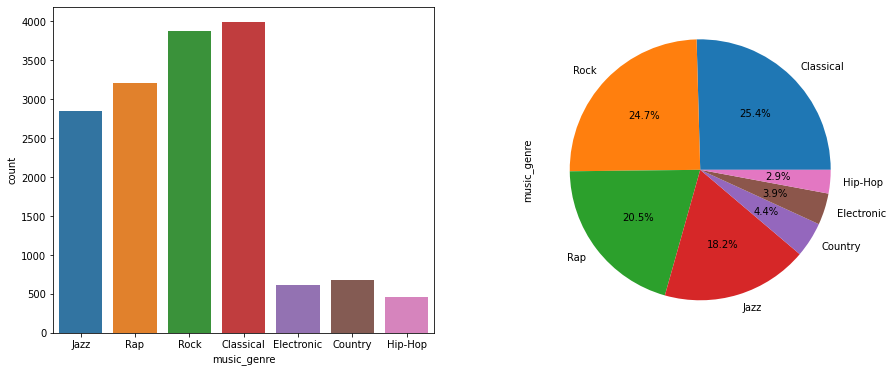

In [66]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
_ = sns.countplot(x=target_col, data=df, ax=ax[0])
_ = df[target_col].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])


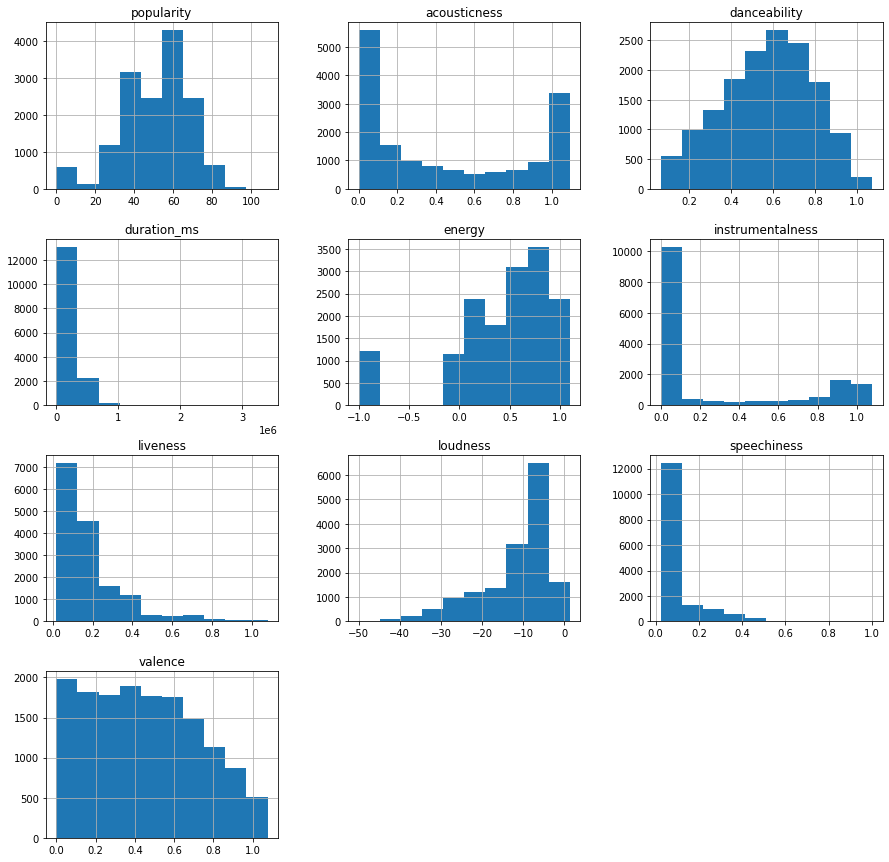

In [67]:
## Histogram Plots
df.hist(figsize=(15,15))
plt.show()

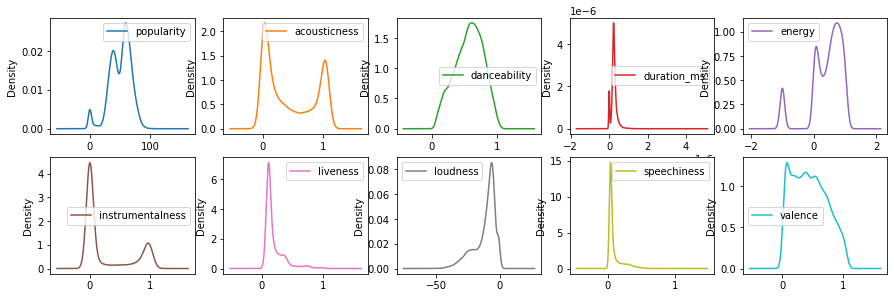

In [68]:
df.plot(kind="density", layout=(6,5), 
             subplots=True,sharex=False, sharey=False, figsize=(15,15))
plt.show()


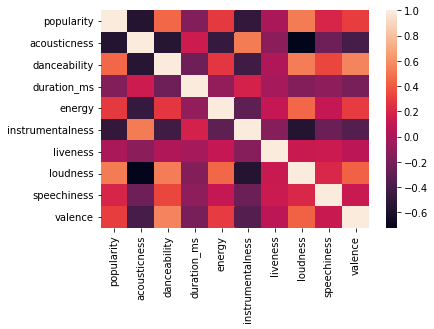

In [69]:
sns.heatmap(df.corr())

# Null data 

In [70]:
## null data 
df.isnull().sum()


instance_id             0
track_name              0
popularity            642
acousticness            0
danceability          556
duration_ms            94
energy                 94
instrumentalness       95
key                     0
liveness                0
loudness               36
voice_gender          765
mode                   35
speechiness            26
tempo                   0
musician_category    1360
valence               677
music_genre             0
dtype: int64

In [71]:
print("Number of Categories in: ")
for ColName in df[["voice_gender","mode","musician_category"]]:
    print("{} = {} and {} ".format(ColName,len(df[ColName].unique()),df[ColName].unique()))

Number of Categories in: 
voice_gender = 4 and [NaN, 'Male', 'Female', 'Both']
Categories (3, object): ['Male', 'Female', 'Both'] 
mode = 4 and ['Major', '?', 'Minor', NaN]
Categories (3, object): ['Major', '?', 'Minor'] 
musician_category = 4 and ['Band', 'Duet', 'Solo', NaN]
Categories (3, object): ['Band', 'Duet', 'Solo'] 


In [72]:
# popularity,danceability,valence are not skewed - mean
# duartion,loudness,speechiness     - median
# energy,instrumentalness   may be mean

## categorical voice_gender,mode,musician_category                                

# Remove Duplicates

In [73]:
# Removes Data Duplicates while Retaining the First one
def remove_duplicate(data):
  data.drop_duplicates(keep="first", inplace=True)
  return "Checked Duplicates"
# Removes Duplicates from train data
remove_duplicate(df)

'Checked Duplicates'

# data Preprocessing

## Nan data 

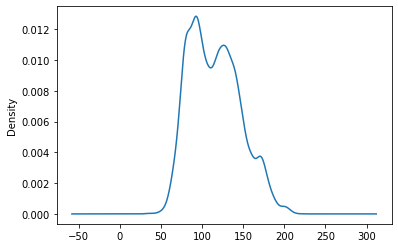

In [74]:
df["tempo"] = df["tempo"].replace('?',np.nan).astype(float)
df["tempo"].plot(kind = "density")

In [75]:
test["tempo"] = test["tempo"].replace('?',np.nan).astype(float)


In [76]:
def impute_nan_create_category(df,ColName):
     df[ColName] = np.where(df[ColName].isnull(),"Unknown",df[ColName])
## Call function to create new category for variables
for Columns in ["voice_gender","mode","musician_category"]:
    impute_nan_create_category(df,Columns)
    impute_nan_create_category(test,Columns)
df["mode"] = df["mode"].str.replace('?',"Unknown")
test["mode"] = test["mode"].str.replace('?',"Unknown")


In [77]:
print("Number of Categories in: ")
for ColName in df[["voice_gender","mode","musician_category"]]:
    print("{} = {} and {} ".format(ColName,len(df[ColName].unique()),df[ColName].unique()))

Number of Categories in: 
voice_gender = 4 and ['Unknown' 'Male' 'Female' 'Both'] 
mode = 3 and ['Major' 'Unknown' 'Minor'] 
musician_category = 4 and ['Band' 'Duet' 'Solo' 'Unknown'] 


In [78]:
for col in ["popularity","danceability","valence","energy","instrumentalness",'tempo']:
  print(col)
  mean = np.mean(df[col])
  df[col].fillna(mean,inplace=True)
  test[col].fillna(mean,inplace=True)

for col in ["duration_ms","loudness","speechiness"]:
  median = df[col].median()
  df[col].fillna(median,inplace=True)
  test[col].fillna(median,inplace=True)

popularity
danceability
valence
energy
instrumentalness
tempo


In [79]:
df["duration_ms"] = df["duration_ms"].apply(lambda x: round(x/1000),2)
test["duration_ms"] = test["duration_ms"].apply(lambda x: round(x/1000),2)


## Feature selection

In [80]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=[object,"category"])
categorical_columns = categorical_columns_selector(df)
categorical_columns.remove("instance_id")
categorical_columns.remove("track_name")
categorical_columns.remove('music_genre')

In [81]:
df["voice_gender"].unique()

array(['Unknown', 'Male', 'Female', 'Both'], dtype=object)

In [82]:
from sklearn import preprocessing
for col in categorical_columns:
  le = preprocessing.LabelEncoder()
  print(col)
  df[col] = le.fit_transform(df[col])
  test[col] = le.transform(test[col])

key
voice_gender
mode
musician_category


In [83]:
features = [col for col in df.columns if col not in [target_col, "track_name","instance_id"]]
features

['popularity',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'voice_gender',
 'mode',
 'speechiness',
 'tempo',
 'musician_category',
 'valence']

In [84]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X=df[features]
Y=le.fit_transform(df[target_col])

In [85]:
dict(zip(le.inverse_transform([0,1,2,3,4,5,6]),[0,1,2,3,4,5,6]))

{'Classical': 0,
 'Country': 1,
 'Electronic': 2,
 'Hip-Hop': 3,
 'Jazz': 4,
 'Rap': 5,
 'Rock': 6}

# Modelling

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, train_size=0.75, random_state=42)
X_test = test

# Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=6, criterion = 'entropy', 
                            min_samples_leaf= 1,min_samples_split= 2)
rf.fit(X_train, y_train)

y_predict_train_rf = rf.predict(X_train)
y_predict_val_rf = rf.predict(X_validation)

train_accuracy_score_rf = accuracy_score(y_train, y_predict_train_rf)
val_accuracy_score_rf = accuracy_score(y_validation, y_predict_val_rf)

print(train_accuracy_score_rf)
print(val_accuracy_score_rf)

0.7579081632653061
0.740627390971691


In [88]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

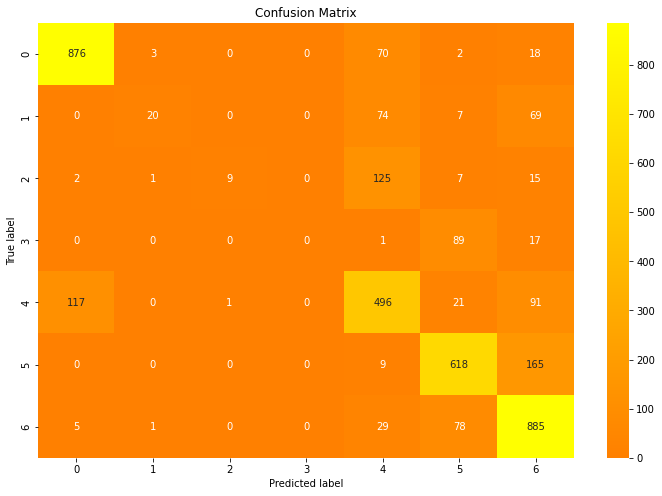

In [89]:
cm_rf = confusion_matrix(y_validation,y_predict_val_rf)
draw_confusion_matrix(cm_rf)

In [90]:
from sklearn.metrics import f1_score
f1_score(y_validation, y_predict_val_rf,average = 'macro')

0.48563909461915283

## Catboost

In [91]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score,f1_score

In [92]:

train_dataset = Pool(data=X_train,
                     label=y_train)

eval_dataset = Pool(data=X_validation,
                    label=y_validation)

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(eval_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_dataset,
                          prediction_type='RawFormulaVal')


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.2301433	total: 27ms	remaining: 243ms
1:	learn: 1.1008851	total: 67.3ms	remaining: 269ms
2:	learn: 1.0185094	total: 95.5ms	remaining: 223ms
3:	learn: 0.9600340	total: 120ms	remaining: 180ms
4:	learn: 0.9152582	total: 150ms	remaining: 150ms
5:	learn: 0.8788485	total: 173ms	remaining: 115ms
6:	learn: 0.8329090	total: 214ms	remaining: 91.8ms
7:	learn: 0.8136067	total: 250ms	remaining: 62.4ms
8:	learn: 0.7998179	total: 273ms	remaining: 30.3ms
9:	learn: 0.7909787	total: 286ms	remaining: 0us


In [93]:
f1_score(preds_class, y_validation,average = 'macro')

0.539886941501089

In [94]:
! pip install hyperopt

In [95]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric=metrics.Accuracy(),
        random_seed=42,
        verbose=False,
        loss_function='MultiClass'    )
    
    cv_data = cv(
        Pool(X, Y),
        model.get_params(),
        logging_level='Silent',
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [ ]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

In [ ]:
cat_model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric=metrics.Accuracy(),
    random_seed=42,
    verbose=False,
    loss_function="MultiClass"
)
cv_data = cv(Pool(X,Y), cat_model.get_params())

# Prediction

In [101]:
results = model.predict(X_test[features])

In [106]:
test_1 = pd.read_csv('test.csv')
data = []
label_dict = {'Classical': 0,'Country': 1,'Electronic': 2,'Hip-Hop': 3,'Jazz': 4,'Rap': 5,'Rock': 6}
label_list = list(label_dict)
for idx,row in test.iterrows():
  data.append([row["instance_id"],label_list[int(results[idx])]])

In [107]:
submission = pd.DataFrame(data= data,columns = ["instance_id","music_genre"])
submission.head()

,instance_id,music_genre
0,MSC_70753.0,Classical
1,MSC_24064.0,Rock
2,MSC_22731.0,Rock
3,MSC_32095.0,Rock
4,MSC_24198.0,Country


In [110]:
submission.to_csv('submission1.csv',index=False)

# To do 

In [ ]:
1 . change milli seconds to seconds